# Covid-19 Outcome Prediction using PySpark and SparkMlLib

The dataset used for this problem is over 1,000,000 rows. PySpark will be utilised to perform the data preprocessing and SparkMlLib will be used to deploy machine learning algorithms, evaluate their performance, and optimise the highest performing models by leveraging the inbuilt pipelines feature.

The dataset can be found at: https://www.kaggle.com/datasets/meirnizri/covid19-dataset

## Initialising Spark Session and Importing Libraries

In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.3.1-bin-hadoop2'

In [2]:
import pyspark
import os
import findspark
import py4j
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import mean,countDistinct, avg,stddev, col, count, when, explode, lit, array
import pyspark.sql.functions as F


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName('project_X').getOrCreate()
spark

## Read In data And Preprocess

The first step of this project is to read in the dataset and get a broad look at the dataset as a whole.

In [4]:
# Import the dataset from the local enironment
df = spark.read.csv('Covid Data.csv', inferSchema=True, header=True)
# Look at the top 10 rows to ensure it has imported correclty
display(df.toPandas().head(10))
# Print the schema to ensure correct data types
df.printSchema()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


root
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- DATE_DIED: string (nullable = true)
 |-- INTUBED: integer (nullable = true)
 |-- PNEUMONIA: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PREGNANT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- COPD: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CHRONIC: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- ICU: integer (nullable = true)



From the initial import,it can be seen that the date died column is in a date. For classification, it would be more useful as a yes/no as to whether the patient died or not. If there is a date in the column, then the patient has died, if not the date was set to 9999-99-99, this will be considered as the patient not having died

In [5]:
# Create a new categorical column containing whether or not the patient died. (values, 2=died, 1=survived)
df = df.withColumn('died', when((df.DATE_DIED == '9999-99-99'), 1).
                        otherwise(2))
# Drop the old date column as it will not be needed
df = df.drop(col('DATE_DIED'))

In [6]:
# Check for null values in the dataframe
df.toPandas().isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
died                    0
dtype: int64

It appears that there are no null values in the dataset. However, the value for null is 97, 98, or 99 for the categorical variables

it can now be seen that there are multiple columns with missing values

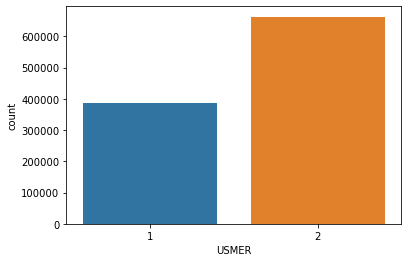

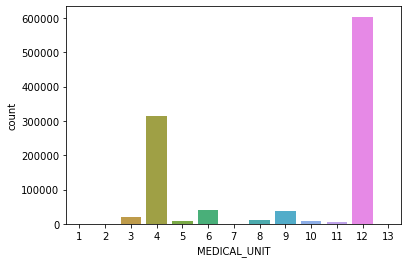

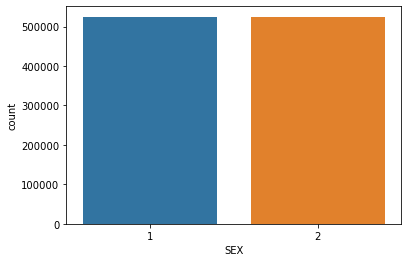

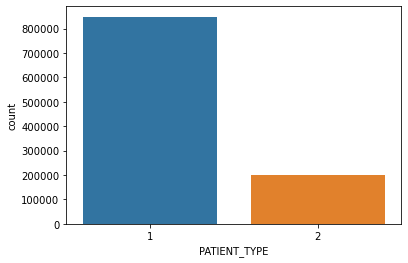

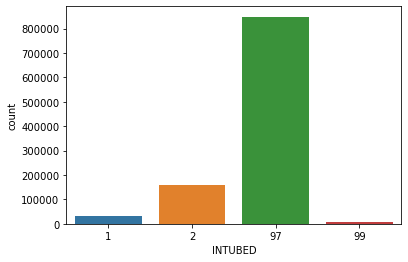

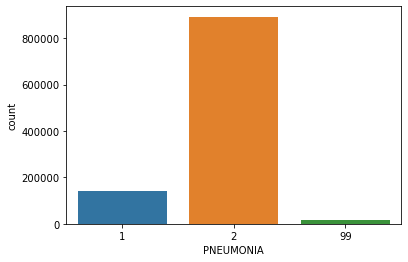

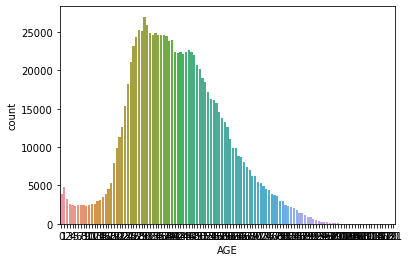

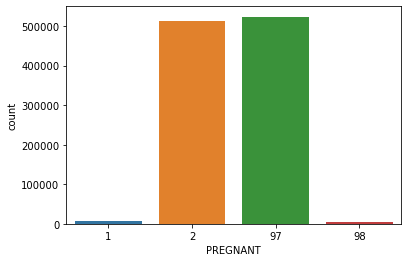

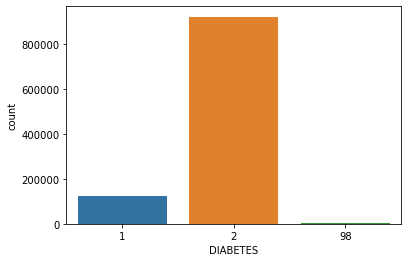

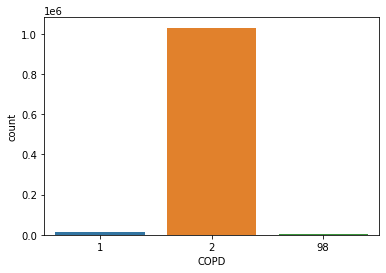

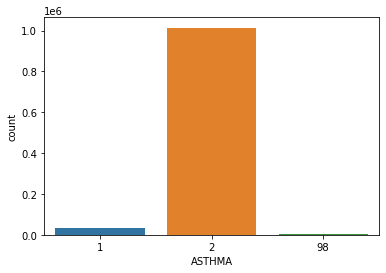

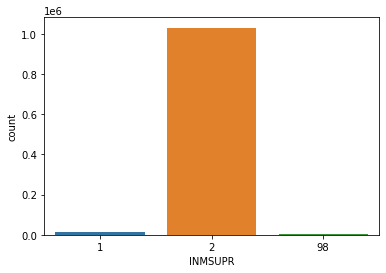

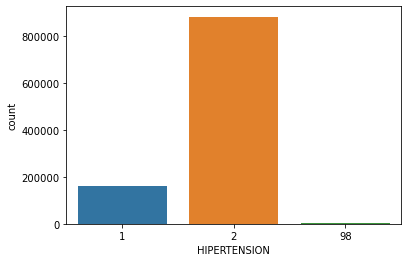

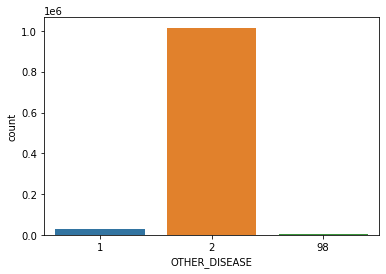

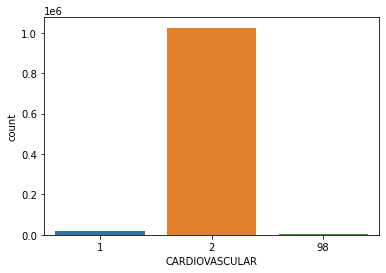

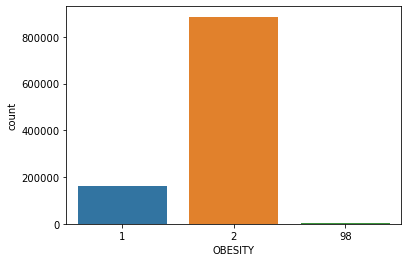

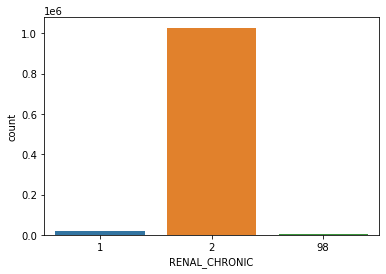

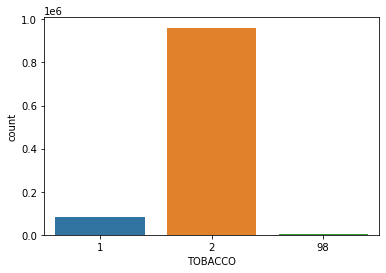

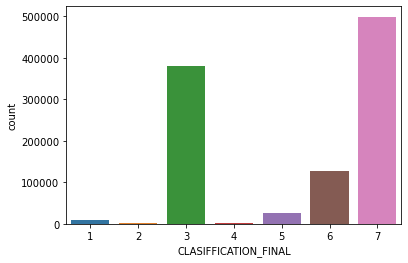

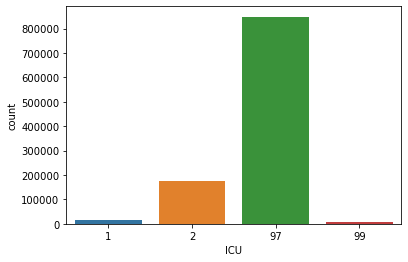

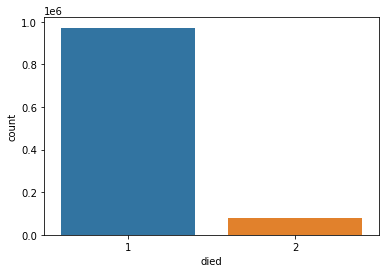

In [7]:
# Visualise the dataset to determine which columns contain null values (97, 98, or 99)
for col in df.columns:
    x = df.select(col).groupBy(col).count().toPandas()
    sns.barplot(x = x[col], y = x['count'])
    plt.show()

To deal with null values, some assumptions have to be made about the data. For the Intubed column, these will be replaced with 1 ( the value for no) as it is assumed that it would be recorded if someone was intubated. For the Pregnant column, these will be replaced with 1 as it is assumed that it would be recorded if someone was pregnant. The same will go for the ICU column as it is assumed that it would be recorded if someone went to the ICU

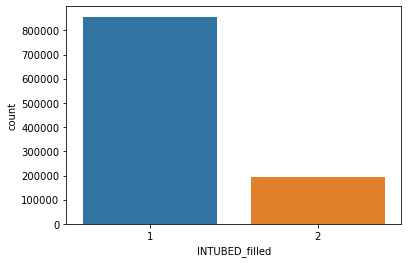

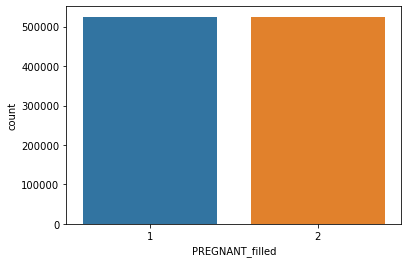

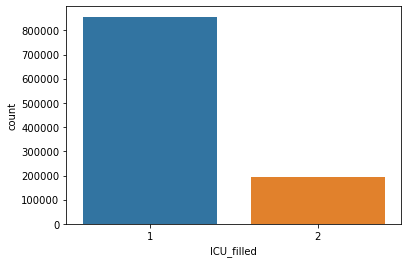

root
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- PNEUMONIA: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- COPD: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CHRONIC: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- died: integer (nullable = false)
 |-- INTUBED_filled: integer (nullable = false)
 |-- PREGNANT_filled: integer (nullable = false)
 |-- ICU_filled: integer (nullable = false)



In [8]:
# Specify which columns contain null values that will be dealt with in this step
null_cols = ['INTUBED', 'PREGNANT', 'ICU']

# Iterate over each of these columns
for col in null_cols:
    
    # Create a new column called 'column_filled', where null values have been replaced
    df = df.withColumn(f'{col}_filled', when(((df[col] == 97) | (df[col] ==99)), 1).
                       otherwise(2))
    # Re-visualise the new column to check everything has worked
    x = df.select(f'{col}_filled').groupBy(f'{col}_filled').count().toPandas()
    sns.barplot(x = x[f'{col}_filled'], y = x['count'])
    plt.show()
    # Drop the old column as it will not be needed
    df = df.drop(df[col])
    
df.printSchema()

for the remaining columns, there are very few missing values and therefore these rows can be dropped

In [9]:
# For every column other than age
for cols in df.drop(df.AGE).columns:
    # Filter out values =99 or 98
    df = df.where((f'{cols} != 99'))
    df = df.where((f'{cols} != 98'))

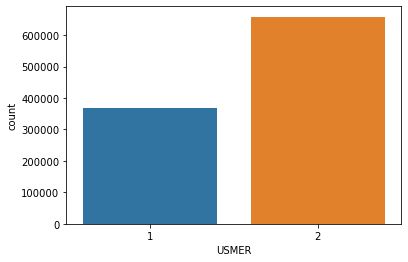

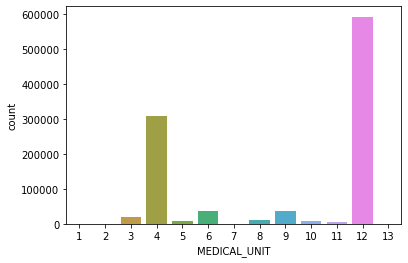

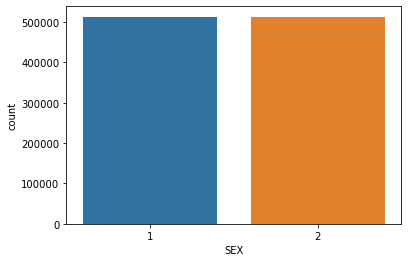

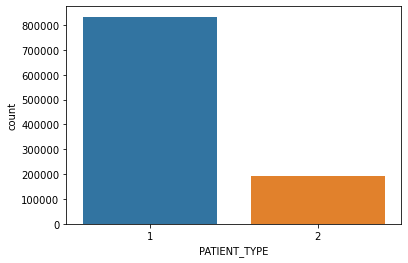

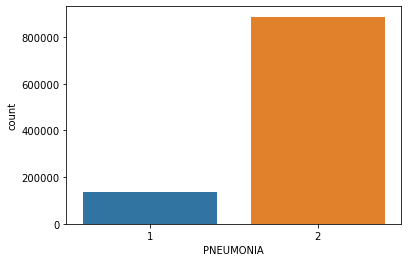

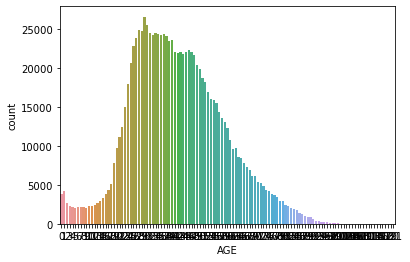

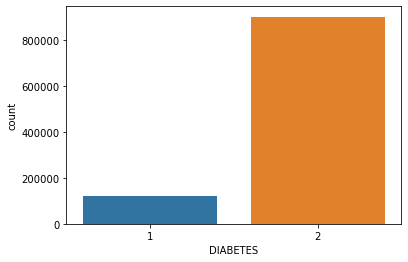

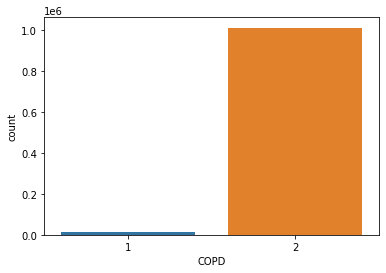

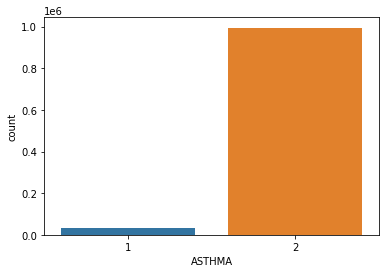

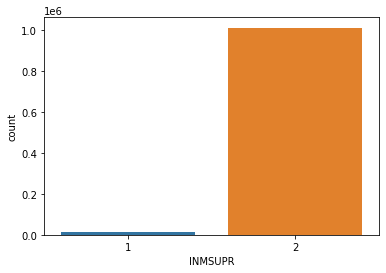

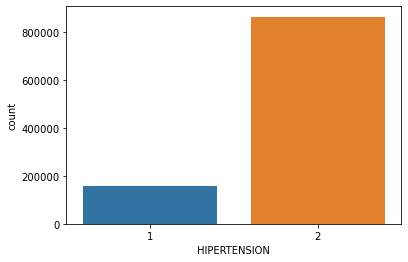

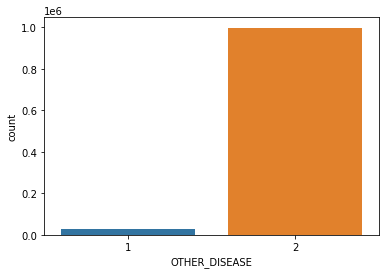

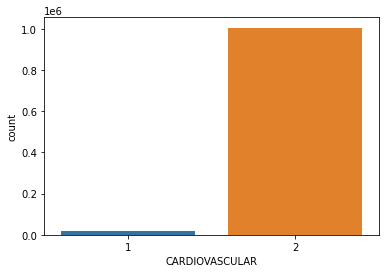

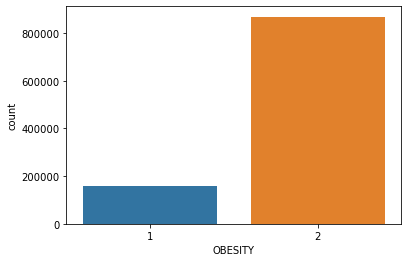

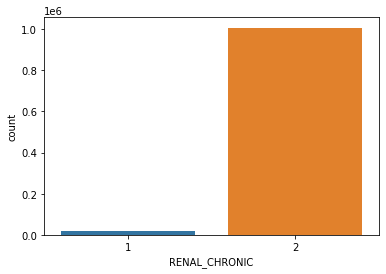

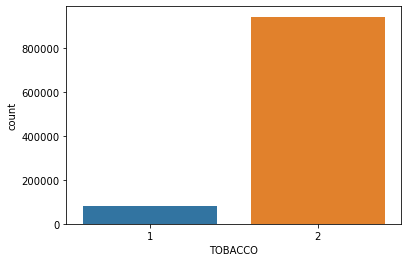

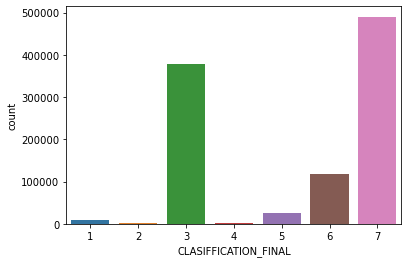

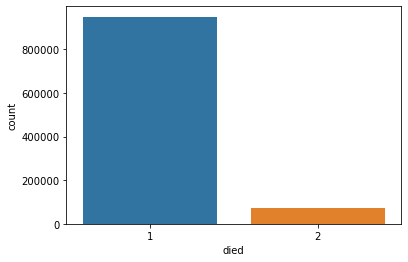

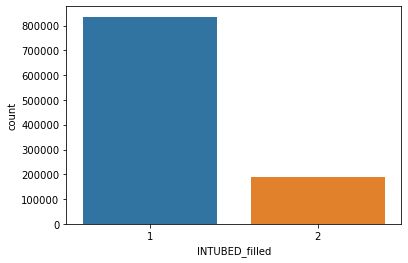

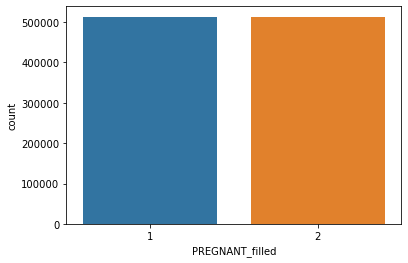

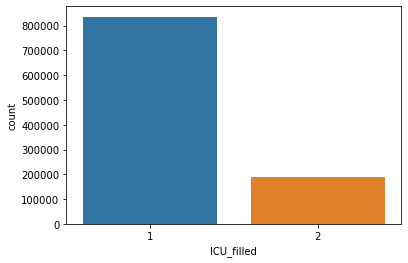

In [10]:
# Re-visualise the columns to check they have all been cleaned properly
for col in df.columns:
    x = df.select(col).groupBy(col).count().toPandas()
    sns.barplot(x = x[col], y = x['count'])
    plt.show()

As there are multiple different outcomes, some of which are repeated, the label variable will be a combination of ICU, Intubed, and died where all of these are considered bad outcomes. A patient will have a bad outcome if any of these columns are true.

<AxesSubplot:xlabel='Outcome', ylabel='count'>

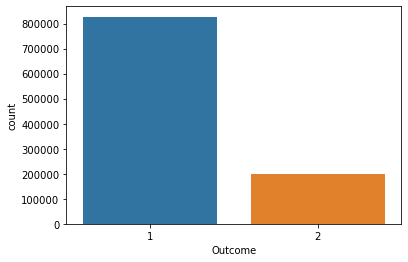

In [11]:
# Create a new column, with the value of 2 (true) when either ICU, INTUBED, or died are true (2)
df = df.withColumn('Outcome', when(((df['ICU_filled'] == 2) | (df['INTUBED_filled'] == 2) | (df['died'] == 2)), 2).
              otherwise(1)
             )
# Visualise the distribution of this column
x = df.select('Outcome').groupBy('Outcome').count().toPandas()
sns.barplot(x = x['Outcome'], y = x['count'])

After the outcomes have been comined, it can be seen that the outcome is unbalanced. As there are over 200,000 data points in the minority class, the data will be undersampled for model fitting. It can also be seen that the categorical variables take the value of 1 and 2 rather than 0 and 1. For binary classification, it is helpful if they are set to 0 for false and 1 for true. The columns will be altered to reflect this

In [12]:
# Specify which of these columns need to have the values changed to bee scaled 0-1 rather than 1-2
cat_cols = ['USMER','SEX','PATIENT_TYPE','PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR',
            'OBESITY','RENAL_CHRONIC','TOBACCO','PREGNANT_filled','Outcome']
# For each of the columns, replace 2 with 1 and 1 with 0
for cols in cat_cols:
    df = df.withColumn(f'{cols}_indexed', when((df[cols] == 2), 1).
                      when((df[cols] == 1), 0).
                      otherwise(0))
    df = df.drop(df[cols])
    

In [13]:
# Begin sampling the dataset.

# First determine the numer of entries in the majority (outcome = 0), and minority (outcome = 1) outcomes
major_df = df.filter(df['Outcome_indexed'] == 0)
minor_df = df.filter(df['Outcome_indexed'] == 1)

# determine the ratio between the majority and minority outcomes. This will be used to determine how much to scale the
# majority outcome by
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 4


404552


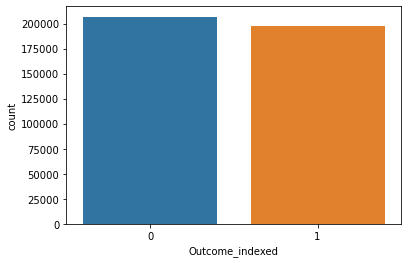

In [14]:
# Sample the majority outcome by selecting 1/ratio (1/4) of the rows
sampled_majority_df = major_df.sample(False, 1/ratio)
# Combine the sampled majority with the minority to 
df_sampled = sampled_majority_df.unionAll(minor_df)
x = df_sampled.select('Outcome_indexed').groupBy('Outcome_indexed').count().toPandas()
sns.barplot(x = x['Outcome_indexed'], y = x['count'])
print(df_sampled.count())

It can now be seen that the dataset is balanced between good and bad outcomes and contains around 400000 rows. Moving forward, it will be useful to scale the age column to prevent bias towards this attribute within the models. However, it is best practice to scale the data after it has been split into trianing and test data. In order to make model selection easier, this will be done by implementing a pyspark pipeline.

<AxesSubplot:xlabel='AGE', ylabel='count'>

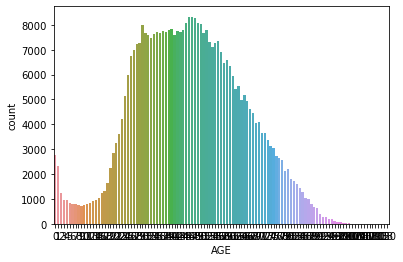

In [15]:
# Plot a barplot of age and count(Age) to visualise the distribution of the variable
x = df_sampled.select('AGE').groupBy('AGE').count().toPandas()
sns.barplot(x = x['AGE'], y = x['count'])

From the above barplot, it can be seen that the age is not normally distributed and therefore will be scaled using min max scaling. The following section outlines the pipeline creation, model definition, and assessment of model performance

In [16]:
# Split the dataset into train and test sets
(training_df, test_df) = df_sampled.randomSplit([0.75,0.25])

In [17]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from sklearn.metrics import classification_report

# Define the feature and label columns to be used in the pipeline
featurecols = ['USMER_indexed','MEDICAL_UNIT','SEX_indexed','PNEUMONIA_indexed','AGE','DIABETES_indexed','COPD_indexed',
               'ASTHMA_indexed','INMSUPR_indexed','HIPERTENSION_indexed','OTHER_DISEASE_indexed','CARDIOVASCULAR_indexed',
               'OBESITY_indexed','RENAL_CHRONIC_indexed','TOBACCO_indexed','CLASIFFICATION_FINAL','PREGNANT_filled_indexed']
labelCol = 'Outcome_indexed'

#Set up PySpark estimators to work in a pipeline and test different classification models

# assembler to combine the feature columns into a single vector
assembler = VectorAssembler(inputCols=featurecols, outputCol = 'features')
# scaler to scale the continuous variables to prevent bias
scaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')

# Define all the models to be tested

# Decision tree classification model
dt = DecisionTreeClassifier(labelCol = labelCol, featuresCol = 'features_scaled')
# Random forest classification model
rf = RandomForestClassifier(labelCol = labelCol, featuresCol = 'features_scaled')
# Support vector machine classification model
svm = LinearSVC(labelCol = labelCol, featuresCol = 'features_scaled')
# Logistic regression classification model
lr = LogisticRegression(labelCol = labelCol, featuresCol = 'features_scaled')

# Set up lists of models and model names so the classification reports can be labelled
ml_lst = [dt, rf, svm, lr]
ml_names = ['Decision Tree','Random Forest', 'Support Vector Machine', 'Binomial Logistic Regression']

# Assess performance of all of the models in the list.
for i in range(len(ml_lst)):
    
    # Set up the pipeline with the model being evaluated and fit to trianing data
    pipeline = Pipeline(stages = [assembler,scaler, ml_lst[i]])
    model = pipeline.fit(training_df)
    
    # Use the fitted model to gain predictions and define the correct outcomes (y_test)
    pred = model.transform(test_df)
    pred_outcomes = pred.select('prediction')
    y_test = test_df.select(labelCol)
    
    # Print the name of the model and the classification report to evaluate performance
    print(ml_names[i],'\n')
    print(classification_report(y_test.toPandas(), pred_outcomes.toPandas()), '\n')

Decision Tree 

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     51679
           1       0.88      0.81      0.84     48934

    accuracy                           0.85    100613
   macro avg       0.85      0.85      0.85    100613
weighted avg       0.85      0.85      0.85    100613
 

Random Forest 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     51679
           1       0.90      0.79      0.84     48934

    accuracy                           0.85    100613
   macro avg       0.86      0.85      0.85    100613
weighted avg       0.86      0.85      0.85    100613
 

Support Vector Machine 

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     51679
           1       0.92      0.74      0.82     48934

    accuracy                           0.84    100613
   macro avg       0.85      0.84      0.84    100613
weighted avg 

From the above classification reports, it can be seen that the decision tree and random forest had the best overall performance. We can now move on to hyperparameter optimisation for the best performing (random forest) models and attempt to further increase their performance. In this case the parameters we are optimising are the number of trees and the maximum tree depth

In [18]:
# re-define the pipeline to be used for parameter optimisation

# assembler to combine the feature columns into a single vector
assembler = VectorAssembler(inputCols=featurecols, outputCol = 'features')
# scaler to scale the continuous variables to prevent bias
scaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')
# random forest classification model 
rf = RandomForestClassifier(labelCol = 'Outcome_indexed', featuresCol = 'features_scaled')

pipeline = Pipeline(stages = [assembler,scaler, rf])

In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#set up the param grid (the parameters to be used for optimisation)
paramGrid = ParamGridBuilder()\
            .addGrid(rf.maxDepth, [3,5,7,10,12,14])\
            .addGrid(rf.numTrees, [15,20,25,30])\
            .build()

# Can cross validate with multiple training sets to further optimise parameter selection
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator().setLabelCol('Outcome_indexed'),
                          numFolds = 5,
                          parallelism = 2)

# Run the cross validataion. This will have 6 x 4 = 24 parameters to choose from over 5 folds so 120 models
cvModel = crossval.fit(training_df)

#Evaluate the model performance
pred = cvModel.transform(test_df)
pred_outcomes = pred.select('prediction')
y_test = test_df.select('Outcome_indexed')
print(classification_report(y_test.toPandas(), pred_outcomes.toPandas()))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     51679
           1       0.90      0.82      0.86     48934

    accuracy                           0.87    100613
   macro avg       0.87      0.86      0.86    100613
weighted avg       0.87      0.87      0.86    100613



It can be seen that the parameter optimisation improved the overall performance of the random forest model with a 0.02 accuracy increase. Whilst this on its own does not appear that large, the precision and recall scores significantly improved, particularly the recall when predicting a negative outcome. From this point it is possible to obtain the feature importances for the final model as shown below.

In [20]:
# Create a list to store the feature importances in
importances = []
# append the list with each element of the feature importances. This will be in the order they were fed into the model
for i in range(17):
    importances.append(cvModel.bestModel.stages[-1].featureImportances[i])

In [21]:
# Specify the columns evaluated in the same order they were fed into the model
importance_cols = ['USMER', 'Medical Unit','Sex', 'Pneumonia', 'Age', 'Diabetes', 'COPD', 'Asthma', 'Immune Suppression',
                  'Hypertension', 'Other Disease', 'Cardiovascular', 'Obesity', 'Chronic Renal Disease', 'Tobacco',
                  'Covid Classification', 'Pregnant']

# Create a dataframe of the feature and its importance and save to csv for final visualisations
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = importance_cols
feature_importance_df['Importance'] = importances
feature_importance_df.to_csv('feature_importance.csv')

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

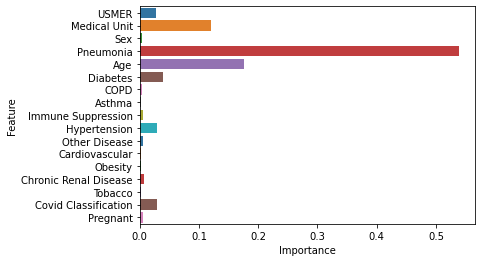

In [22]:
# Visualise the feature importances
sns.barplot(data = feature_importance_df, x = 'Importance', y = 'Feature', palette = 'tab10')

It can be seen from the above graph that whether or not a patient has pneumonia is of key importance when predicting covid-19 patient outcomes, along with age and diabetes. From here, it would be usesful to extract the best parameters for the random forest model. The following section extracts the parameters from each model trained, plots thier performance, and highlights the parameters of the best performing model

In [30]:
# Define lists for the maxDepth and numTrees parameters and append them with the values for each model tested
depth = []
trees = []
for i in range(24):
    depth.append(list(paramGrid[i].values())[0])
    trees.append(list(paramGrid[i].values())[1])

# Extract the average performance of each model tested. This number provides a good means to compare between the models
performance = cvModel.avgMetrics

In [31]:
# Store the parameters and their models' respective performance in a pandas dataframe
optimisation_df = pd.DataFrame()
optimisation_df['Max Depth'] = depth
optimisation_df['Num Trees'] = trees
optimisation_df['Avg_Performance'] = performance
optimisation_df.to_csv('rf_performance.csv')

# Find the row in the dataframe with the best performance
best_index = np.where(optimisation_df['Avg_Performance'] == max(optimisation_df['Avg_Performance']))[0][0]
# Extract the best performing numTrees and maxDepth
best_trees = optimisation_df['Num Trees'][best_index]
best_depth = optimisation_df['Max Depth'][best_index]

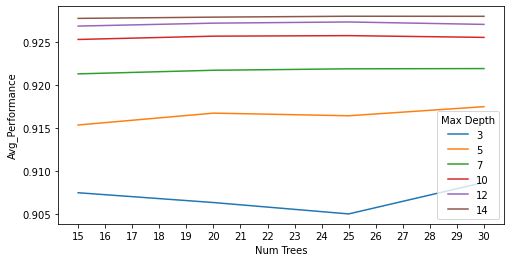

The best performing Random Forest model contained 25 Trees with a Max depth of 14


In [32]:
# Visualise the performance of the diferent models
fig, axes = plt.subplots(figsize = (8,4))
plt.xticks(np.arange(15, 31, 1))
sns.lineplot(data = optimisation_df, x = 'Num Trees', y = 'Avg_Performance', hue = 'Max Depth', palette='tab10')
plt.show()
# Highlight the parameters of the best performing model
print(f'The best performing Random Forest model contained {best_trees} Trees with a Max depth of {best_depth}')

Overall, this notebook has covered the whole data science process on the dataset for predicting covid-19 outcome. From data cleaning, to feature engineering, model selection and model optimisation. Multiple machine learning models were implemented and evaluated, with the random forest model performing best. This model was then optimised through tuning the hyperparameters to improve the performance.

In [ ]:
spark.stop()